In [1]:
import torch
import torch.nn as nn
import torch_geometric
from src.layer.encoders import TrigonometricEncoder
from src.model.wavegc import WaveGCNet
from src.transforms.spectral import WaveGCSpectralTransform

<Axes: >

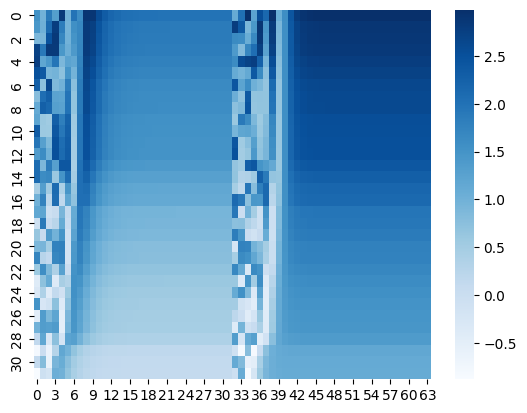

In [2]:
import numpy as np 
import seaborn as sns

eigvs = torch.tensor(np.random.uniform(0,2, (1, 32) ),
                      dtype=torch.float32).sort(
    axis=1,descending=True).values
d = 64

pe = TrigonometricEncoder(d, 100, project=False)
pos = pe(eigvs)
sns.heatmap(pos.detach(), cmap='Blues')

In [3]:
from torch_geometric.datasets import Amazon

dataset = Amazon(root='/tmp/Amazon', name='Photo')

In [4]:
transform = WaveGCSpectralTransform('short', top_k_pct=0.1, threshold=0.1)

In [5]:
data = transform(dataset.data)

/Users/sgerasimov/Desktop/WaveGN/wavegc/.venv/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [6]:
np.random.seed(42)
train_mask = torch.tensor(
    np.random.choice([True, False], size=data.num_nodes, p=[0.8, 0.2])
)

In [7]:
data.train_mask = train_mask

In [8]:
test_mask = ~train_mask
data.test_mask = test_mask

In [64]:
inp_dim = data.x.shape[1]
emb_dim, pe_dim = 32, 16
eigvs_dim = data.eigvs.shape[1]
hidden_dim = 32
lape_hidden_num = 1
out_dim = data.y.unique().shape[0]
K, J = 6, 3
x, eigvs, U = data.x, data.eigvs, data.U

In [65]:
model = WaveGCNet(
        inp_dim=inp_dim,
        out_dim=out_dim,
        emb_dim=emb_dim, 
        pe_dim=pe_dim, 
        eigvs_dim=eigvs_dim,
        lape_hidden_num=lape_hidden_num,
        hidden_dim=hidden_dim, 
        heads_num=4,
        scale=torch.tensor([1.0]*J), 
        num_layers=4,
        mpnn="gcn",
        K=K,
        J=J,
        tight_frames=True,
        dropout=0.2,
        ffn_hidden_num=2,
        mpnn_hidden_num=1,
        eps=100,
        aggr="sum",
    )

In [66]:
class SimpleGCN(nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_dim, hidden_num=3):
        super().__init__()
        self.inp_dim, self.out_dim = inp_dim, out_dim
        self.hidden_dim = hidden_dim
        act = nn.GELU

        self.conv = torch_geometric.nn.GCN(
                    in_channels=inp_dim,
                    hidden_channels=hidden_dim,
                    num_layers=hidden_num,
                    act = act(),
                    #norm = nn.BatchNorm1d(hidden_dim)
                )
        self.out = nn.Linear(hidden_dim, out_dim)
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return self.out(x)

#model = SimpleGCN(inp_dim, out_dim, hidden_dim)


In [67]:
print("Number of Parameters: ", sum([param.numel() for param in model.parameters()]))

Number of Parameters:  121285


In [68]:
epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=0.01)
Loss = nn.CrossEntropyLoss()

100%|██████████| 20/20 [05:43<00:00, 17.18s/it]


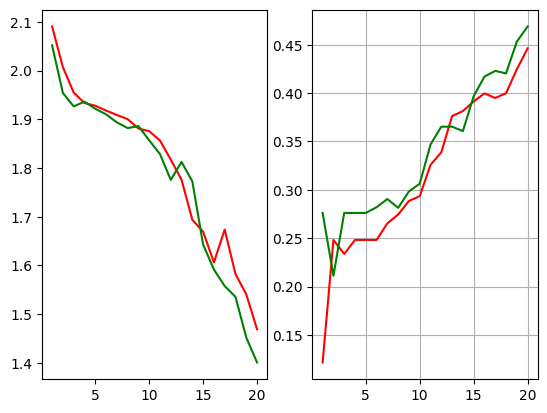

In [69]:
from tqdm import tqdm
import matplotlib.pyplot as plt
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in tqdm(range(epochs)):

    model.train()

    try:
        logits = model(data.x, data.edge_index, data.eigvs, data.U)[data.train_mask]
    except:
        logits = model(data.x, data.edge_index)[data.train_mask]

    target = data.y[train_mask]
    loss = Loss(logits, target)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss.append(loss.detach().cpu().numpy())
    pred = logits.argmax(dim=1).detach().cpu().numpy()
    
    train_accuracy.append(np.mean((pred == target.cpu().numpy())))

    model.eval()

    try:
        logits = model(data.x, data.edge_index, data.eigvs, data.U)[data.test_mask]
    except:
        logits = model(data.x, data.edge_index)[data.test_mask]

    target = data.y[test_mask]
    loss = Loss(logits, target)

    optim.zero_grad()
    loss.backward()
    optim.step()

    test_loss.append(loss.detach().cpu().numpy())
    pred = logits.argmax(dim=1).detach().cpu().numpy()
    
    test_accuracy.append(np.mean((pred == target.cpu().numpy())))



_, ax = plt.subplots(1,2)

ax[0].plot(np.arange(epochs)+1, train_loss, c='r')
ax[0].plot(np.arange(epochs)+1, test_loss, c='g')


ax[1].plot(np.arange(epochs)+1, train_accuracy, c='r')
ax[1].plot(np.arange(epochs)+1, test_accuracy, c='g')


plt.grid()


    

In [15]:
test_accuracy[-1]

np.float64(0.27672131147540985)